In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.datasets import make_classification


In [57]:
df = pd.read_csv('data/master_df.csv', index_col='created_at')
df.index = pd.to_datetime(df.index, unit='s')
df.head()


,backers_count,blurb,category,converted_pledged_amount,country,country_displayable_name,creator,currency,currency_symbol,currency_trailing_code,...,source_url,spotlight,staff_pick,state,state_changed_at,static_usd_rate,urls,usd_exchange_rate,usd_pledged,usd_type
created_at,,,,,,,,,,,,,,,,,,,,,
2020-12-31 01:00:06,18,A cookbook for lyke minded poeple who love sim...,"{""id"":306,""name"":""Cookbooks"",""analytics_name"":...",5034,US,the United States,"{""id"":1076439302,""name"":""Ali"",""slug"":""lykemind...",USD,$,True,...,https://www.kickstarter.com/discover/categorie...,True,False,successful,1611968831,1.000000,"{""web"":{""project"":""https://www.kickstarter.com...",1.000000,5034.000000,international
2020-11-25 04:29:20,508,A cookbook filled with memoirs and recipes fro...,"{""id"":306,""name"":""Cookbooks"",""analytics_name"":...",48365,HK,Hong Kong,"{""id"":974771323,""name"":""Peggy Chan"",""slug"":""ch...",HKD,$,True,...,https://www.kickstarter.com/discover/categorie...,True,True,successful,1614096106,0.128984,"{""web"":{""project"":""https://www.kickstarter.com...",0.128976,48368.291331,international
2020-11-27 11:38:16,14,Zine de libro de recetas para estudiantes,"{""id"":306,""name"":""Cookbooks"",""analytics_name"":...",98,ES,Spain,"{""id"":1376613464,""name"":""Asociación Trece Aran...",EUR,€,False,...,https://www.kickstarter.com/discover/categorie...,True,False,successful,1607900340,1.196375,"{""web"":{""project"":""https://www.kickstarter.com...",1.211149,96.906412,international
2020-11-04 14:41:45,1486,"A Chef's Guide to Hunting, Preparing and Cooki...","{""id"":306,""name"":""Cookbooks"",""analytics_name"":...",127765,US,the United States,"{""id"":365711508,""name"":""Jesse Griffiths"",""slug...",USD,$,True,...,https://www.kickstarter.com/discover/categorie...,True,True,successful,1610082068,1.000000,"{""web"":{""project"":""https://www.kickstarter.com...",1.000000,127765.690000,international
2020-11-15 15:38:47,249,A selection of the recipes we love from the co...,"{""id"":306,""name"":""Cookbooks"",""analytics_name"":...",14574,GB,the United Kingdom,"{""id"":349330105,""name"":""Eilis and Emma"",""slug""...",GBP,£,False,...,https://www.kickstarter.com/discover/categorie...,True,True,successful,1608573895,1.327616,"{""web"":{""project"":""https://www.kickstarter.com...",1.336255,14480.304767,international


In [58]:
# read category data for name and parent name
df_category = pd.read_csv('data/category.csv')
df_category = df_category[['name', 'parent_name']]
nlp_data = df[['blurb', 'slug', 'country']] 

In [59]:
# drop columns deemed unessecary
model_data = df.drop(columns = ['is_starrable','current_currency','static_usd_rate','usd_exchange_rate','usd_type','id','name', 'slug', 'category', 'creator', 'location', 'photo', 'profile', 'urls', 'country_displayable_name', 'currency_symbol', 'currency_trailing_code', 'disable_communication', 'source_url', 'currency', 'pledged', 'blurb'])
#model_data = model_data.loc[~df.index.duplicated(keep='first')]
#df_category = model_data.loc[~df.index.duplicated(keep='first')]

# create goal_usd column so that all goal amounts are in the same units, drop fx_rate and goals afterward
model_data['goal_usd'] = model_data['fx_rate']*model_data['goal']
#model_data = model_data.drop(columns=['fx_rate', 'goal'])

# combine category data and all other date
model_data = pd.concat([model_data, df_category], axis=1, join='inner')

# create percentage funded column as another metric
model_data['percentage_funded'] = model_data.converted_pledged_amount/model_data.goal_usd*100

# create total days active column as another metric
model_data['total_days_active'] = (model_data.deadline-model_data.created_at)*0.00001157

model_data

InvalidIndexError: Reindexing only valid with uniquely valued Index objects

In [60]:
#model_data.index.is_unique()
df_category.index.is_unique()

TypeError: 'bool' object is not callable

In [61]:
model_data = model_data.dropna() 
model_data.isna().sum().sum()

0

In [62]:
# drop rows that have state 'live' or 'cancelled'
#model_data = model_data.drop(model_data[model_data['state'] == 'live'].index, axis=0)
#odel_data = model_data.drop(model_data[model_data['state'] == 'canceled'].index, axis=0)
#model_data = model_data.reset_index(drop=True)
#model_data.head()
#model_data.head()

In [63]:
# split into X and y variables
X = model_data.drop(columns=['state'])
y = model_data.state.to_frame()

In [64]:
# generate 70% train/test split 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [65]:
# init encoder for x values
encoder = LabelEncoder()

# encode boolean and string type columns
encoding_columns = (X.select_dtypes(include=['bool', 'object'])).columns
for column in encoding_columns:
    X_train[column] = encoder.fit_transform(X_train[column])
    X_test[column] = encoder.transform(X_test[column])

C:\Users\jimp\anaconda3\envs\pyvizenv\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\jimp\anaconda3\envs\pyvizenv\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [66]:
# new encoder for y variable (to make sure that we can reverse encoding)
y_encoder = LabelEncoder()
y_train['state'] = y_encoder.fit_transform(y_train['state'])
y_test['state'] = y_encoder.transform(y_test['state'])

C:\Users\jimp\anaconda3\envs\pyvizenv\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\jimp\anaconda3\envs\pyvizenv\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [67]:
# init standard scaler
scaler = MinMaxScaler()

# scale Train and testing set, columns=X.columns to keep column headers.
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X.columns)
X_train_scaled.head()

,backers_count,converted_pledged_amount,country,deadline,fx_rate,goal,launched_at,spotlight,staff_pick,state_changed_at,usd_pledged,goal_usd
0,0.000410,0.000049,0.375,0.595330,1.000000,0.000018,0.598380,1.0,0.0,0.602878,0.000050,0.000039
1,0.003842,0.002087,1.000,0.517886,0.765387,0.001513,0.519022,1.0,1.0,0.524452,0.002087,0.002500
2,0.000065,0.000006,0.375,0.585370,1.000000,0.000024,0.586771,0.0,0.0,0.592792,0.000006,0.000052
3,0.000086,0.000029,1.000,0.262931,0.765387,0.000020,0.263157,1.0,0.0,0.266264,0.000029,0.000033
4,0.000329,0.000288,1.000,0.946743,0.765387,0.000095,0.954411,1.0,0.0,0.958746,0.000288,0.000157


In [68]:
from ast import literal_eval

categories = df.category.apply(literal_eval).to_frame()
categories = pd.json_normalize(categories.category)
categories


,id,name,analytics_name,slug,position,parent_id,parent_name,color,urls.web.discover
0,306,Cookbooks,Cookbooks,food/cookbooks,3,10.0,Food,16725570,http://www.kickstarter.com/discover/categories...
1,306,Cookbooks,Cookbooks,food/cookbooks,3,10.0,Food,16725570,http://www.kickstarter.com/discover/categories...
2,306,Cookbooks,Cookbooks,food/cookbooks,3,10.0,Food,16725570,http://www.kickstarter.com/discover/categories...
3,306,Cookbooks,Cookbooks,food/cookbooks,3,10.0,Food,16725570,http://www.kickstarter.com/discover/categories...
4,306,Cookbooks,Cookbooks,food/cookbooks,3,10.0,Food,16725570,http://www.kickstarter.com/discover/categories...
...,...,...,...,...,...,...,...,...,...
30987,47,Fiction,Fiction,publishing/fiction,7,18.0,Publishing,14867664,http://www.kickstarter.com/discover/categories...
30988,47,Fiction,Fiction,publishing/fiction,7,18.0,Publishing,14867664,http://www.kickstarter.com/discover/categories...
30989,47,Fiction,Fiction,publishing/fiction,7,18.0,Publishing,14867664,http://www.kickstarter.com/discover/categories...
30990,47,Fiction,Fiction,publishing/fiction,7,18.0,Publishing,14867664,http://www.kickstarter.com/discover/categories...


In [47]:
print("Build Neural Networks classifier")

Build Neural Networks classifier


In [70]:
# init and fit Neural Networks classifier
X = [[0., 0.], [1., 1.]]
y = [0, 1]
nn_clf = MLPClassifier(solver='lbfgs', alpha=1e-5,
                       hidden_layer_sizes=(6, 2), random_state=1)

nn_clf.fit(X, y)
MLPClassifier(alpha=1e-05, hidden_layer_sizes=(6, 2), random_state=1,
              solver='lbfgs')
nn_clf.fit(X_train_scaled, y_train.state)

MLPClassifier(alpha=1e-05, hidden_layer_sizes=(6, 2), random_state=1,
              solver='lbfgs')

In [71]:
# perform predictions on testing data
prediction_nn  = nn_clf.predict(X_test_scaled)

In [72]:
# print classification report
print(classification_report(y_test, prediction_nn))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       277
           1       0.85      1.00      0.92      2881
           2       0.00      0.00      0.00       219
           3       1.00      1.00      1.00      5921

    accuracy                           0.95      9298
   macro avg       0.46      0.50      0.48      9298
weighted avg       0.90      0.95      0.92      9298



C:\Users\jimp\anaconda3\envs\pyvizenv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\jimp\anaconda3\envs\pyvizenv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\jimp\anaconda3\envs\pyvizenv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [73]:
# view confusion matrix
cm = confusion_matrix(y_test, prediction_nn)
cm

array([[   0,  277,    0,    0],
       [   0, 2881,    0,    0],
       [   0,  219,    0,    0],
       [   0,    0,    0, 5921]], dtype=int64)

In [74]:
working_df = df[['goal', 'pledged', 'state']]
working_df.head()

,goal,pledged,state
created_at,,,
2020-12-31 01:00:06,5000.0,5034.00,successful
2020-11-25 04:29:20,350000.0,374995.00,successful
2020-11-27 11:38:16,50.0,81.00,successful
2020-11-04 14:41:45,65000.0,127765.69,successful
2020-11-15 15:38:47,10600.0,10907.00,successful


In [75]:
# Instantiate a linear SVM model
from sklearn.neural_network import MLPClassifier
classifier = MLPClassifier(kernel='linear',max_iter=100000)
classifier

TypeError: __init__() got an unexpected keyword argument 'kernel'

AttributeError: 'MLPClassifier' object has no attribute 'feature_importances_'

In [188]:
working_df.sample(20)

,goal,pledged,state
created_at,,,
2017-03-27 17:02:13,5000.0,12798.00,successful
2016-07-05 11:56:42,4800.0,14010.00,successful
2017-12-01 07:31:06,50000.0,51700.00,successful
2021-10-08 14:20:18,5000.0,5914.29,successful
2016-12-20 18:02:12,2000.0,2359.00,successful
2014-05-21 01:15:47,2000.0,2001.00,successful
2012-04-17 00:38:15,10000.0,10510.07,successful
2019-07-13 04:56:22,50000.0,59208.00,successful
2011-03-23 21:55:14,2000.0,2090.00,successful


In [189]:
working_df['percentage_funded'] = working_df.pledged/working_df.goal*100

C:\Users\jimp\anaconda3\envs\pyvizenv\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [190]:
working_df

,goal,pledged,state,percentage_funded
created_at,,,,
2020-12-31 01:00:06,5000.0,5034.00,successful,100.680000
2020-11-25 04:29:20,350000.0,374995.00,successful,107.141429
2020-11-27 11:38:16,50.0,81.00,successful,162.000000
2020-11-04 14:41:45,65000.0,127765.69,successful,196.562600
2020-11-15 15:38:47,10600.0,10907.00,successful,102.896226
...,...,...,...,...
2015-06-21 16:51:44,3000.0,3395.00,successful,113.166667
2015-08-27 02:48:20,12000.0,21112.15,successful,175.934583
2015-09-01 12:42:36,2000.0,2000.00,successful,100.000000


<AxesSubplot:xlabel='created_at'>

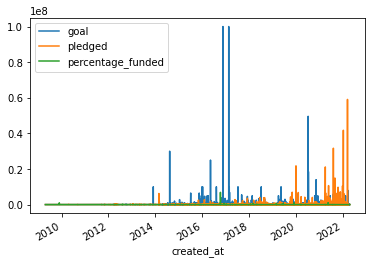

In [191]:
working_df.sort_values(by='percentage_funded', ascending=False).plot()

In [192]:
working_df.sort_values(by='percentage_funded', ascending=False)

,goal,pledged,state,percentage_funded
created_at,,,,
2016-10-11 23:14:53,1.00,68764.1,successful,6876410.0
2021-05-18 02:37:11,1.00,10834.0,successful,1083400.0
2009-11-25 06:07:11,0.01,100.0,successful,1000000.0
2019-12-03 16:00:23,1.00,9935.0,successful,993500.0
2016-12-05 20:08:39,1.00,7529.0,successful,752900.0
...,...,...,...,...
2016-09-13 13:39:51,153000.00,0.0,failed,0.0
2017-01-15 21:21:44,3500.00,0.0,failed,0.0
2017-01-28 15:52:15,20000.00,0.0,failed,0.0


<AxesSubplot:xlabel='created_at'>

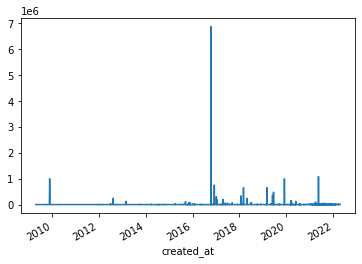

In [193]:
working_df['percentage_funded'].plot()

<AxesSubplot:xlabel='state'>

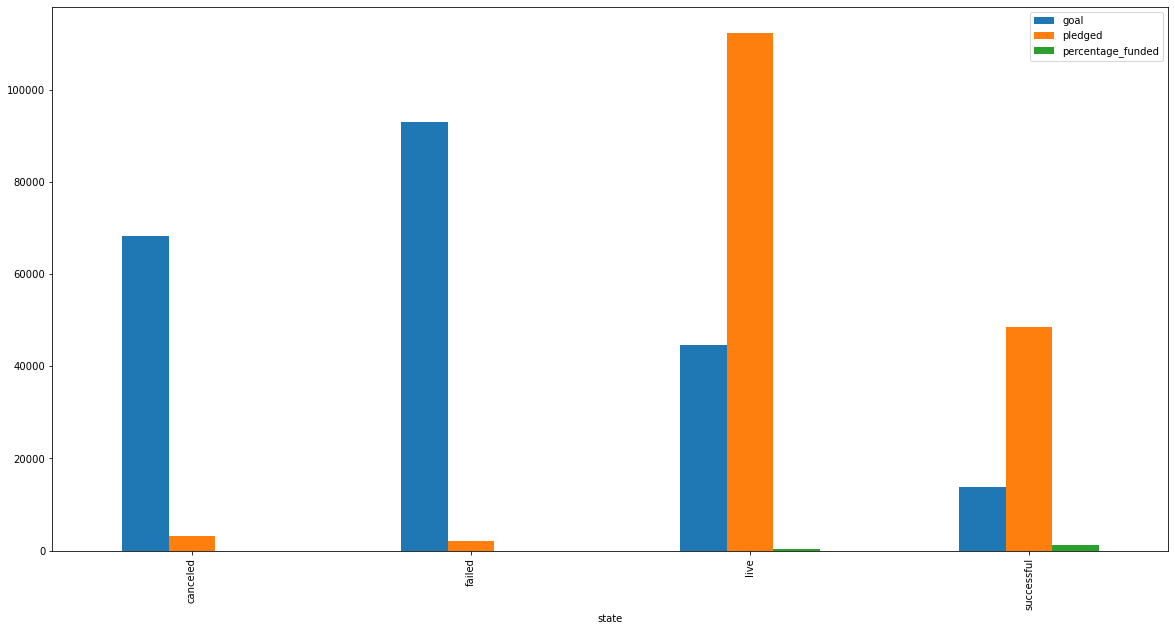

In [194]:
working_df.groupby('state').mean().plot.bar(figsize=(20,10), sharex=True)